# Margem de Ganho e de Fase

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from control import tf, bode, nyquist, feedback, step_response
from sympy import var, Lambda, log

In [16]:
class MargemGanho:

    def __init__(self, G):
        self.G = G
        self.Gc = 1
    
    def parameters(self):
        mag, phase, omega = bode(self.G, db=True, plot=False)#, omega_limits=[1/1000, 1000])
        magdb = 20 * np.log10(np.abs(mag))
        phasedg = 180 / np.pi * phase
        return omega, magdb, phasedg
    
    def pontos(self, omega, mag, phase):
        w_db = w_deg = j = k = 0
        
        try:
            while mag[j] > 0:
                j += 1
            w_db = omega[j]
        except IndexError:
            j = j -1
            w_db = omega[j]
        try:
            while phase[k] > -180:
                k += 1
            w_deg = omega[k]
        except IndexError:
            k = k-1 
            w_deg = omega[k]
        return (j,w_db, k , w_deg)
    
    def plot(self):
        omega, magdb, phasedg = self.parameters()
        j,w_db, k, w_deg = self.pontos(omega, magdb, phasedg)
        
        print(' '*14,'************************************************')
        print(' '*28, f'Margem de Ganho dB: {np.round(-magdb[k], 2)}\n')
        print(' '*28,f'Margem de Fase: {np.round(180 + phasedg[j], 2)}')
        print(' '*14,'************************************************')
        
        plt.figure(figsize=(9, 6))
        
        plt.style.use('default')
        
        plt.subplot(211)
        plt.semilogx()
        plt.title('Diagrama de Bode', fontsize=18, fontfamily='monospace', fontweight='bold')
        plt.ylabel('Magnitude (dB)', fontsize=16, fontfamily='serif')
        plt.plot(omega, magdb, linewidth=2, color = 'brown')
        plt.plot([w_db], [0], marker='o', color = 'black', linewidth=2, label='ganho = 0')
        plt.plot([w_deg], magdb[k], marker='o', color = 'blue', linewidth=2, label= f'ganho = {magdb[k]:.2f}')
        plt.plot(omega, [0 for i in omega], color = 'black', alpha=0.5)
        plt.fill_between(omega[j:k], 0, magdb[j:k] , where = magdb[j:k] < 0 , color='green', alpha=0.5)
        plt.tight_layout()
        plt.fill_between(omega[k:j], 0, magdb[k:j] , where = magdb[k:j] > 0 , color='red', alpha=0.5)
        plt.legend(fontsize=14, frameon=True, framealpha = 0.5, facecolor='white', loc=0)
        plt.grid()
        
        plt.subplot(212)
        plt.semilogx()
        plt.ylabel('Fase (deg)', fontsize=16, fontfamily = 'serif')
        plt.xlabel('Frequência (rad/s)', fontsize=16, fontfamily = 'serif')
        plt.plot(omega, phasedg, linewidth=2, color='brown')
        plt.plot([w_deg], [-180], marker='o', color = 'blue', linewidth=2, label='fase = -180')
        plt.plot([w_db], [phasedg[j]], marker='o', color = 'black', linewidth=2, label=f'fase = {phasedg[j]:.2f}')
        plt.plot(omega, [-180 for i in omega], color = 'blue', alpha=0.5)
        plt.tight_layout()
        plt.fill_between(omega[k:j], phasedg[k:j], -180 , where = phasedg[k:j] < -180, color='red', alpha=0.5)
        plt.fill_between(omega[j:], phasedg[j:], -180 , where = phasedg[j:] > -180, color='green', alpha=0.5)
        plt.legend(fontsize=14, frameon=True, framealpha = 0.5, facecolor='white', loc=0)
        plt.grid()
        
        plt.show()
        
        
    def nyq(self):
        plt.style.use('default')
        nyquist(self.G, omega = np.logspace(-3, 3, 1000))
        
        
    def Gav(self, MF, gk=1, S=0):
        print('Primeiramente iremos plotar o diagrama de bode de KGH')
        mag, phase, omega = bode(gk * self.G, db=True, plot=False, omega_limits = [1/1000, 1000])
        magdb = 20 * np.log10(np.abs(mag))
        phasedg = 180 / np.pi * phase

        ###
        j = 0
        while magdb[j] > 0:
            j += 1
        wc = omega[j]
        ###
        GF = MF - 180 - phasedg[j] + S
        GFr = GF * (np.pi / 180)

        ###
        a = (1-np.sin(GFr))/(1 + np.sin(GFr))
        Kdb = 20*np.log10(gk/np.sqrt(a))
       
        ###
        k = 0
        while magdb[k] + Kdb -20 * np.log10(gk) > 0:
            k+=1
        wm = omega[k]
        ###
        T = 1 / (wm * np.sqrt(a))



        ### Plotagem
        plt.style.use('default')
        plt.subplot(211)
        plt.semilogx()
        plt.title('Diagrama de Bode de KG(s)H(s)')
        plt.ylabel('Magnitude (dB)')
        plt.plot(omega, magdb)
        plt.plot([wm], [-Kdb + 20*np.log10(gk)], marker='o')
        plt.plot([wc], [0], marker='o')
        plt.grid()

        plt.subplot(212)
        plt.semilogx()
        plt.ylabel('Fase (deg)')
        plt.xlabel('Frequência (rad/s)')
        plt.plot(omega, phasedg)
        plt.grid()

        plt.show()
        #####




        print(f'Agora perceba que a frequência de cruzamento é:\nWc = {wc:.3f} rad/s\n')
        #######


        print(f'Para esta frequência temos que a fase é:\nFase(G(jWc)) = {phasedg[j]:.3f} deg\n')
        
        print(f'Portanto, como MF = 180 + Fase(G(jw)H(jw)) + Fase(Gav(jw)), e queremos MF = {MF} temos que\n'
              'o incremento de fase Phi_m será:\n'
              f'Phi_m = {round(GF - S, 3)} + {S} deg\n')
        ######


        print(f'Agora, calculando o valor de a, temos:\na = {a:.3f}\n')
        print(f'Calculando também o ganho do controlador na frequência Wm:\nKdB = {Kdb:.3f} dB\n')
        #######


        print('Agora, para calcular a frequência Wm, devemos verificar em qual frequência\n'
        'o valor do ganho em dB da planta(G(jw)) é igual do controlador, e este valor de frequência é:\n'
        f'Wm = {wm:.3f} rad/s\n')

        #####


        print('Por fim, agora temos nossos 2 parametros a serem definidos: "T" e "a" que são:\n'
        f'T = {T:.4f} s\n'
        f'a = {a:.3f}\n')
        
        print('Sendo assim, nosso controlador é dado por:', gk / a * tf([1, 1/T], [1, 1/(a*T)]) )
        
        
        self.Gc = gk / a * tf([1, 1/T], [1, 1/(a*T)])      
        


        return gk / a * tf([1, 1/T], [1, 1/(a*T)])

    def Gat(self, MF, gk, S):
        print('Primeiramente iremos plotar o diagrama de bode de KGH')
        mag, phase, omega = bode(gk * self.G, db=True, plot=False)
        magdb = 20 * np.log10(np.abs(mag))
        phasedg = 180 / np.pi * phase


        fase_planta = MF + S - 180

        j = 0
        while phasedg[j] - fase_planta > 0:
            j += 1
        wc = omega[j]

        T = 10 / wc
        An = magdb[j]
        B = 10 ** (An/20)


        ### Plotagem
        plt.style.use('default')
        plt.subplot(211)
        plt.semilogx()
        plt.title('Diagrama de Bode de KG(s)H(s)')
        plt.ylabel('Magnitude (dB)')
        plt.plot(omega, magdb)
        plt.plot([wc], [An], marker='o')
        plt.grid()             

        plt.subplot(212)
        plt.semilogx()
        plt.ylabel('Fase (deg)')
        plt.xlabel('Frequência (rad/s)')
        plt.plot(omega, phasedg)
        plt.plot([wc], [fase_planta], marker='o')
        plt.grid()
        plt.show()
        #####

        print(f'Agora veja que a nova frequência de cruzamento será:\n'
        f'Wc = {wc:.3f} rad/s\n')

        print('Apos isto, veja que o ganho de |KG(jwc)|dB é:\n'
             f'|KG(jWc)|dB = {An:.3f} dB\n')

        print(f'Portanto, o controlador deverá contribuir com {-An:.3f} dB quando a frequência for {wc:.3f} rad/s\n')

        print('Sendo assim, o valor de B será:\n'
             f'B = {B:.3f}\n')

        print('Para evitar constantes de tempo altas, utilizaremos uma frequência de canto\n'
             f'que esteja uma decada antes de {wc:.3f}, portanto:\n'
             f'T = {T:.3f} s\n')

        print('Agora, como todos os parametros já foram definidos, temos que o controlador em atraso será:\n')

        print(f'{gk/B* tf([1, 1/T], [1, 1/(B*T)])}')
        
        self.Gc = gk / B * tf([1, 1/T], [1, 1/(B*T)])

        return gk / B * tf([1, 1/T], [1, 1/(B*T)])


    def Gvt(self, MF, gk, S):
        print('Primeiramente iremos plotar o diagrama de bode de KGH')
        mag, phase, omega = bode(gk * self.G, db=True, plot=False)
        magdb = 20 * np.log10(np.abs(mag))
        phasedg = 180 / np.pi * phase

        j = 0
        while phasedg[j] + 180 > 0:
            j += 1
        wc = omega[j]

        T2 = 10 / wc
        An = magdb[j]
        
        polos = self.G.pole()
        zeros = self.G.zero()
        
        if 0 in polos:
            polos = np.delete(polos, np.where(polos == 0)[0][0])
        
        C = np.abs(np.prod(zeros)/ np.prod(polos))
        
        k = -20 * np.log10(gk * C)
        #k = -30
        B = (1 + np.sin(np.deg2rad(MF + S))) / (1 - np.sin(np.deg2rad(MF + S)))
        P = (round(wc, 3), -round(An, 3))
        w1, w2, eq = self.avanco(P, k)


        Gcav = tf([1, w1], [1, w2])
        Gcat = tf([1, 1/T2], [1, 1/(B * T2)])


        ### Plotagem
        plt.style.use('default')
        plt.subplot(211)
        plt.semilogx()
        plt.title('Diagrama de Bode de KG(s)H(s)')
        plt.ylabel('Magnitude (dB)')
        plt.plot(omega, magdb)
        #plt.plot(omega, 20 * np.log10(omega) -13.42)
        #plt.plot([wc], [An], marker='o')
        plt.grid()             

        plt.subplot(212)
        plt.semilogx()
        plt.ylabel('Fase (deg)')
        plt.xlabel('Frequência (rad/s)')
        plt.plot(omega, phasedg)
        plt.plot([wc], [-180], marker='o')
        plt.grid()
        plt.show()
        #####

        print('*' * 120,'\n')

        print('Apartir de agora, iremos determinar a nova frequência de cruzamento, que acontece quando fase(KG(jw))= -180 deg\n'
             'portanto, a nova frequência de corte é:\n'
             f'Wc = {wc:.3f} rad/s\n')

        print(f'Determinaremos, portanto que deverá haver um ganho de fase (Phi) na frequência {wc:.3f} rad/s de {MF} deg.\n'
             f'Phi = {MF} + {S} deg\n')

        print('Em posse do valor de Phi, podemos calcular o valor de B, portanto:\n'
             f'B = {B:.3f}\n')

        print('Determinando a frequência de canto, como estando uma decada abaixo, temos então:\n'
             f'T2 = {T2:.3f} s\n')

        print('Em posse dos valores de B e T2 nosso controlador em atraso já está completamente definido, sendo:', Gcat,'\n')

        print('*' * 120,'\n')

        print('Agora, para a parte em avanço de fase, traçaremos uma reta com inclinação de 20dB por decada e que\n'
             f'passa pelos pontos {P}, sendo assim, obtemos a seguinte equação:\n'
             f'{eq(w)}\n')

        print(f'Por fim, pegando os valores de frequência onde a reta tem magnitude 0dB e {k:.3f}dB, temos:\n'
             f'W1 = {w1:.3f} rad/s e W2 = {w2:.3f} rad/s \n')

        print('Com isso, temos que o compensador de avanço de fase é: ', Gcav, '\n')

        print('*' * 120,'\n')
        
        self.Gc = gk * Gcat * Gcav

        return gk * Gcat * Gcav

    def avanco(self, P, k):
        var('w')
        A = 20
        B = P[1] - 20 * np.log10(P[0])
        w1 = 10 ** ((k - B)/A)
        w2 = 10 ** ((0 - B)/A)
        return w1, w2, Lambda(w, 20*log(w) + B)
    
    
    def plot_tempo(self, In = 0):
        F = feedback(self.G)
        F_compensado = feedback(self.Gc * self.G)
        if In == 0:
            t, y = step_response(F, np.linspace(0, 40, 1000))
            t_com, y_com = step_response(F_compensado, np.linspace(0, 40, 1000))
            plt.plot(t, y, label='Sem Compensador',color='black')
            plt.plot(t_com, y_com, label='Com Compensador',color='red')
            plt.plot(t_com, [1 for i in t_com], label='Referência', alpha=0.5, linewidth=3,color='brown')
            plt.xlabel('Tempo (s)')
            plt.ylabel('Tensão (V)')
            plt.grid()
            plt.legend(loc = 0)
            
            plt.savefig('grafico_degrau.png', dpi=600)
            plt.show()
            
            
        elif In == 1:
            T = tf([1], [1, 0])
            t, y = step_response(F * T, np.linspace(0, 10, 1000))
            t_com, y_com = step_response(F_compensado * T, np.linspace(0, 10, 1000))
            plt.plot(t, y, label='Sem Compensador',color='black')
            plt.plot(t_com, y_com, label='Com Compensador',color='red')
            plt.plot(t_com, t_com, label='Referência', alpha=0.5, linewidth=3,color='brown')
            plt.xlabel('Tempo (s)')
            plt.ylabel('Tensão (V)')
            plt.grid()
            plt.legend(loc = 0)
            
            plt.savefig('grafico_rampa.png', dpi=600)
            plt.show()
            
        
        

### Calculo da função de transferencia de malha aberta

In [21]:
G1 = tf([1], [1, 0])
G2 = tf([1], [1, 1])
G3 = tf([1], [1, 4])
G = G1 * G2 * G3

Primeiramente iremos plotar o diagrama de bode de KGH


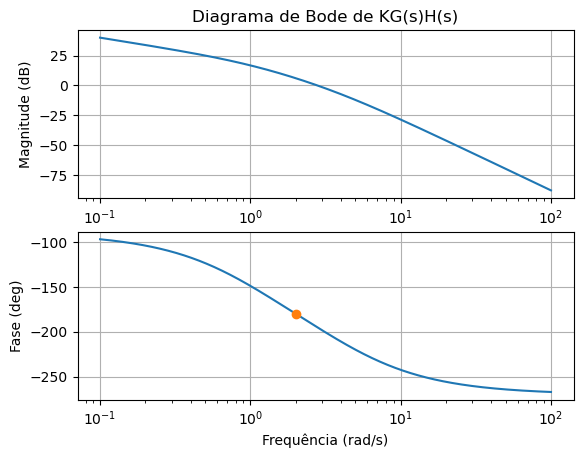

************************************************************************************************************************ 

Apartir de agora, iremos determinar a nova frequência de cruzamento, que acontece quando fase(KG(jw))= -180 deg
portanto, a nova frequência de corte é:
Wc = 2.010 rad/s

Determinaremos, portanto que deverá haver um ganho de fase (Phi) na frequência 2.010 rad/s de 50 deg.
Phi = 50 + 5 deg

Em posse do valor de Phi, podemos calcular o valor de B, portanto:
B = 10.059

Determinando a frequência de canto, como estando uma decada abaixo, temos então:
T2 = 4.974 s

Em posse dos valores de B e T2 nosso controlador em atraso já está completamente definido, sendo: 
 s + 0.201
-----------
s + 0.01999
 

************************************************************************************************************************ 

Agora, para a parte em avanço de fase, traçaremos uma reta com inclinação de 20dB por decada e que
passa pelos pontos (2.01, -5.93), sendo assim, obtemos

In [22]:
controller = MargemGanho(G)
Gc = controller.Gvt(50, 40, 5)

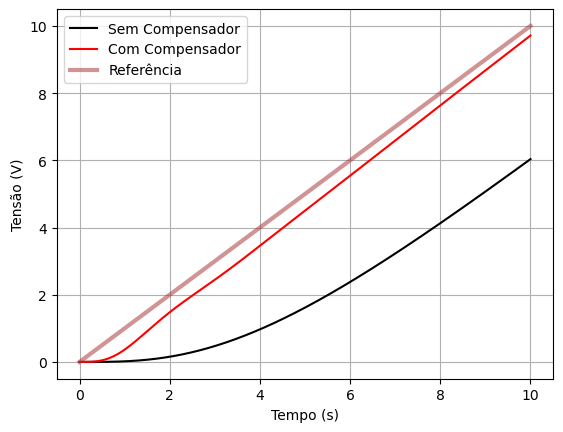

In [23]:
controller.plot_tempo(1)